In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import random
seed = 42
torch.manual_seed(seed)  # For PyTorch CPU
torch.cuda.manual_seed(seed)  # For PyTorch GPU (if available)
np.random.seed(seed)  # For NumPy
random.seed(seed)  # For Python's random module
torch.backends.cudnn.deterministic = True  # For reproducibility on GPUs
torch.backends.cudnn.benchmark = False  # Make sure cudnn is deterministic


os.makedirs("learning_curves", exist_ok=True)
os.makedirs("comparison_plots", exist_ok=True)


# Load and prepare data
data = pd.read_csv("merged_data.csv")
data = data.dropna()

# Rename columns to handle case sensitivity
data = data.rename(columns={'pid': 'PID', 'Time': 'time'})

# Convert time to datetime
data['time'] = pd.to_datetime(data['time'], unit='ms')

# Verify PID column exists
if 'PID' not in data.columns:
    raise ValueError("PID column not found in data. Available columns: " + ", ".join(data.columns))

# Create time index for each PID group
data['time_index'] = data.groupby('PID').cumcount()

# Select features and target (we'll predict TAC_Reading)
X = data[['Pe_results', 'Comp_results']].values  # Features
y = data['TAC_Reading'].values  # Target (TAC_Reading)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Reshape for regression

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor, y_tensor = X_tensor.to(device), y_tensor.to(device)

# Create sequential batches
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data)-seq_length):
        sequences.append(data[i:i+seq_length])
    return torch.stack(sequences)

# Example usage for LSTM:
seq_length = 10  # Look at past 10 readings
X_seq = create_sequences(X_tensor, seq_length)
y_seq = y_tensor[seq_length-1:]  # Align targets

# ===================== Model Definitions (Same as Before) ===================== #
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class RNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class CNN(nn.Module):
    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=1, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.fc1 = nn.Linear(16 * input_size, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize models
input_size = X.shape[1]
models = {
    'FNN': FNN().to(device),
    'RNN': RNN().to(device),
    'LSTM': LSTM().to(device),
    'CNN': CNN(input_size).to(device)
}



def train_model_with_validation(model, X_train, y_train, X_test, y_test, model_name, epochs, lr=0.001):
    model_folder = f'model_{model_name}_{epochs}_epochs'
    os.makedirs(model_folder, exist_ok=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, test_losses, total_losses = [], [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        train_loss = criterion(outputs, y_train)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

        total_loss = (
            train_loss.item() * len(X_train) +
            test_loss.item() * len(X_test)
        ) / (len(X_train) + len(X_test))
        total_losses.append(total_loss)

    # Save losses
    losses_df = pd.DataFrame({
        'epoch': range(epochs),
        'train_loss': train_losses,
        'test_loss': test_losses,
        'total_loss': total_losses
    })
    losses_df.to_csv(f'{model_folder}/losses.csv', index=False)

    # Save model weights
    torch.save(model.state_dict(), f'{model_folder}/{model_name}.pth')

    # Save learning curve plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.plot(total_losses, label='Total Loss')
    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_folder}/learning_curves.png')
    plt.close()

    return train_losses, test_losses, total_losses, model_folder


def plot_separate_loss_curves(model_names):
    """Plot separate curves with improved titles for generalization performance"""
    
    # Plot 1: Train Loss
    plt.figure(figsize=(12, 6))
    for model_name in model_names:
        try:
            curve_data = pd.read_csv(f'learning_curves/{model_name}_learning_curve.csv')
            plt.plot(curve_data['epoch'], curve_data['train_loss'], label=f'{model_name} Train Loss')
        except FileNotFoundError:
            print(f"Warning: Train loss data not found for {model_name}")
    plt.title("Train Generalization Performance Over Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('learning_curves/train_loss_all_models.png')
    plt.show()
    
    # Plot 2: Test Loss
    plt.figure(figsize=(12, 6))
    for model_name in model_names:
        try:
            curve_data = pd.read_csv(f'learning_curves/{model_name}_learning_curve.csv')
            plt.plot(curve_data['epoch'], curve_data['test_loss'], label=f'{model_name} Test Loss')
        except FileNotFoundError:
            print(f"Warning: Test loss data not found for {model_name}")
    plt.title("Test Generalization Performance Over Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('learning_curves/test_loss_all_models.png')
    plt.show()


def plot_predictions_with_boundary(y_train, y_test, y_pred, model_name):
    y_train_cpu = y_train.detach().cpu().numpy().flatten()
    y_test_cpu = y_test.detach().cpu().numpy().flatten()
    y_pred_cpu = y_pred.detach().cpu().numpy().flatten()

    # Combine train and test for continuity
    full_true = np.concatenate([y_train_cpu, y_test_cpu])
    full_pred = np.concatenate([y_train_cpu, y_pred_cpu])  # use true train + predicted test

    # Take last 200 points
    true_zoomed = full_true[-200:]
    pred_zoomed = full_pred[-200:]

    plt.figure(figsize=(12, 5))
    plt.plot(true_zoomed, label='True TAC', linewidth=2)
    plt.plot(pred_zoomed, label='Predicted TAC', linewidth=2, linestyle='--')
    plt.axhline(0.08, color='red', linestyle='--', label='Sober Boundary')
    plt.title(f'{model_name} - Last 200 Steps Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('TAC Reading')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"comparison_plots/{model_name}_predictions.png")
    plt.close()



def calculate_mae(y_true, y_pred):
    """Calculate Mean Absolute Error (MAE)"""
    return mean_absolute_error(y_true, y_pred)



def calculate_normalized_rmse(y_true, y_pred):
    """Normalized RMSE: RMSE divided by the range of true values"""
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (np.max(y_true) - np.min(y_true))


def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error (RMSE)"""
    return np.sqrt(mean_squared_error(y_true, y_pred))


def plot_metric_histogram(values, metric_name, model_names):
    plt.figure(figsize=(8, 4))
    bars = plt.bar(model_names, values, color='skyblue', edgecolor='black')
    plt.title(f'{metric_name} Comparison Across Models')
    plt.ylabel(metric_name)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Place value labels *just* above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height * 0.98, f'{height:.2f}',
                 ha='center', va='top', fontsize=10, color='black')

    plt.tight_layout()
    plt.savefig(f'comparison_plots/{metric_name.replace(" ", "_").lower()}_histogram.png')
    plt.close()


In [19]:
data.columns

Index(['PID', 'Axis', 'Pe_results', 'Comp_results', 'TAC_Reading', 'time',
       'Sober_classification', 'time_index'],
      dtype='object')

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def calculate_sober_classification_metrics(y_true, y_pred, threshold=0.08):
    y_true_class = (y_true > threshold).astype(int)
    y_pred_class = (y_pred > threshold).astype(int)

    acc = np.mean(y_true_class == y_pred_class)
    prec = precision_score(y_true_class, y_pred_class)
    rec = recall_score(y_true_class, y_pred_class)
    f1 = f1_score(y_true_class, y_pred_class)
    
    try:
        auc = roc_auc_score(y_true_class, y_pred)  # Use raw scores for AUC
    except ValueError:
        auc = 0.0  # Fallback if only one class present

    return acc * 100, prec, rec, f1, auc


In [17]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=seed)
    X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # Define custom epochs for each model
    epochs_map = {
        'FNN': 300,
        'RNN': 300,
        'LSTM': 300,
        'CNN': 300
    }

    # Storage for comparison plots
    rmse_scores = []
    mae_scores = []
    nrmse_scores = []
    sober_accuracies = []
    model_names = []

    for model_name, model in models.items():
        epochs = epochs_map.get(model_name, 300)
        print(f"\nTraining {model_name} with validation for {epochs} epochs...")

        # Train and get model folder
        train_losses, test_losses, total_losses, model_folder = train_model_with_validation(
            model, X_train, y_train, X_test, y_test, model_name, epochs=epochs
        )

        # Evaluate on test set
        with torch.no_grad():
            model.eval()
            y_pred = model(X_test)
            y_pred_cpu = y_pred.detach().cpu().numpy().flatten()
            y_test_cpu = y_test.detach().cpu().numpy().flatten()

            # Calculate metrics
            rmse = calculate_rmse(y_test_cpu, y_pred_cpu)
            mae = calculate_mae(y_test_cpu, y_pred_cpu)
            nrmse = calculate_normalized_rmse(y_test_cpu, y_pred_cpu)
            acc, prec, rec, f1, auc = calculate_sober_classification_metrics(y_test_cpu, y_pred_cpu)


            rmse_scores.append(rmse)
            mae_scores.append(mae)
            nrmse_scores.append(nrmse)
            sober_accuracies.append(acc)
            model_names.append(model_name)

     


            # Save predictions vs actuals
            pd.DataFrame({
                'True_TAC': y_test_cpu,
                'Predicted_TAC': y_pred_cpu,
                'True_Sober': (y_test_cpu > 0.08).astype(int),
                'Predicted_Sober': (y_pred_cpu > 0.08).astype(int)
            }).to_csv(f"{model_folder}/predictions_vs_actuals.csv", index=False)

            pd.DataFrame([{
                'RMSE': rmse,
                'MAE': mae,
                'NRMSE': nrmse,
                'Sober Classification Accuracy (%)': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'AUC': auc
            }]).to_csv(f"{model_folder}/metrics.csv", index=False)

        # Save prediction plot
        plot_predictions_with_boundary(y_train, y_test, y_pred, model_name)

    # Plot histograms across all models
    plot_metric_histogram(rmse_scores, 'RMSE', model_names)
    plot_metric_histogram(mae_scores, 'MAE', model_names)
    plot_metric_histogram(nrmse_scores, 'Normalized RMSE', model_names)
    plot_metric_histogram(sober_accuracies, 'Sober Classification Accuracy (%)', model_names)
    plot_metric_histogram([prec], 'Precision', model_names)
    plot_metric_histogram([rec], 'Recall', model_names)
    plot_metric_histogram([f1], 'F1 Score', model_names)
    plot_metric_histogram([auc], 'AUC', model_names)




    


Training FNN with validation for 300 epochs...

Training RNN with validation for 300 epochs...


/Users/mane/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training LSTM with validation for 300 epochs...

Training CNN with validation for 300 epochs...


    RESERVOIR PART

In [383]:

import scipy.sparse as sparse
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()


X_flat = X_seq.view(X_seq.shape[0], -1).T.cpu().numpy()
y_flat = y_seq[:X_flat.shape[1]].T.cpu().numpy()
X_flat = scaler_X.fit_transform(X_flat.T).T  # scale each input dim across time
y_flat = scaler_y.fit_transform(y_flat.T).T


res_params = {
    "radius": 0.95,         # Try increasing slightly for more dynamic memory
    "degree": 10,           # Increase connectivity
    "sigma": 1.0,           # Stronger input influence
    "train_length": X_flat.shape[1],
    "N": 5000,              # Larger reservoir
    "num_inputs": X_flat.shape[0],
    "predict_length": 200,
    "beta": 1e-5,           # Stronger regularization
}

# Define Echo State Network (ESN) functions
def generate_reservoir(size, radius, degree):
    """Generates the reservoir matrix A."""
    sparsity = degree / float(size)
    A = sparse.rand(size, size, density=sparsity).todense()
    vals = np.linalg.eigvals(A)
    e = np.max(np.abs(vals))
    A = (A / e) * radius
    return A


def reservoir_layer(A, Win, input, res_params):
    """Computes the state of the reservoir for given inputs."""
    states = np.zeros((res_params["N"], res_params["train_length"]))
    for i in range(res_params["train_length"] - 1):
        states[:, i + 1] = np.tanh(np.dot(A, states[:, i]) + np.dot(Win, input[:, i]))
    return states


def train_reservoir(res_params, data):
    """Trains using the trained reservoir."""
    A = generate_reservoir(res_params["N"], res_params["radius"], res_params["degree"])
    q = int(res_params["N"] / res_params["num_inputs"])
    Win = np.zeros((res_params["N"], res_params["num_inputs"]))
    for i in range(res_params["num_inputs"]):
        np.random.seed(seed=i)
        Win[i * q : (i + 1) * q, i] = res_params["sigma"] * (
            -1 + 2 * np.random.rand(1, q)[0]
        )

    states = reservoir_layer(A, Win, data, res_params)
    Wout = train(res_params, states, data)
    x = states[:, -1]
    return x, Wout, A, Win


def train(res_params, states, data):
    """Sets up and trains an ESN using input data."""
    beta = res_params["beta"]
    idenmat = beta * sparse.identity(res_params["N"])
    states2 = states.copy()
    for j in range(2, np.shape(states2)[0] - 2):
        if np.mod(j, 2) == 0:
            states2[j, :] = (states[j - 1, :] * states[j - 2, :]).copy()
    U = np.dot(states2, states2.transpose()) + idenmat
    Uinv = np.linalg.inv(U)
    Wout = np.dot(Uinv, np.dot(states2, data.transpose()))
    return Wout.transpose()


def predict(A, Win, res_params, x, Wout):
    """Predicts future states using the trained reservoir."""
    output = np.zeros((res_params["num_inputs"], res_params["predict_length"]))
    # print(x.shape)

    for i in range(res_params["predict_length"]):
        x_aug = x.copy()
        # print("x_aug")
        # print(x_aug.shape)
        for j in range(2, np.shape(x_aug)[0] - 2):
            if np.mod(j, 2) == 0:
                x_aug[j] = (x[j - 1] * x[j - 2]).copy()
        # print(np.asarray(np.dot(Wout,x_aug).shape))
        out = np.squeeze(np.asarray(np.dot(Wout, x_aug)))
        output[:, i] = out
        x1 = np.tanh(np.dot(A, x) + np.dot(Win, out))
        x = np.squeeze(np.asarray(x1))
    return output, x


x, Wout, A, Win = train_reservoir(res_params, X_flat)
predicted_y, _ = predict(A, Win, res_params, x, Wout)

predicted_y = predicted_y[0]  # Get the first output dimension (assuming TAC_Reading is first)

# Make sure we're comparing the same number of samples
min_length = min(len(y_flat[0]), len(predicted_y))
y_true = y_flat[0, -min_length:].flatten()  # Take the last min_length samples
y_pred = predicted_y[-min_length:].flatten()  # Take the last min_length predictions
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()


rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("Rmse", rmse)

Rmse 0.04875945492323691


In [386]:
def plot_esn_full_predictions(y_true, y_pred, model_name="ESN_Model"):
    import matplotlib.pyplot as plt
    import numpy as np

    assert len(y_true) == len(y_pred), "Predictions and true values must be the same length."

    diff = np.abs(y_true - y_pred)

    plt.figure(figsize=(15, 5))
    plt.plot(y_true, label='True TAC', linewidth=2)
    plt.plot(y_pred, label='Predicted TAC', linewidth=2, linestyle='--', alpha=0.9)
    plt.axhline(0.08, color='red', linestyle=':', label='Sober Threshold (0.08)', linewidth=1.5)

    # Optional: highlight areas where prediction deviates > 0.02
    plt.fill_between(np.arange(len(y_true)), y_true, y_pred,
                     where=diff > 0.02, color='orange', alpha=0.3,
                     label='Deviation > 0.02')

    plt.title(f"{model_name} - Full Time Series Prediction")
    plt.xlabel("Time Step")
    plt.ylabel("TAC Reading")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"comparison_plots/{model_name}_full_prediction.png")
    plt.show()


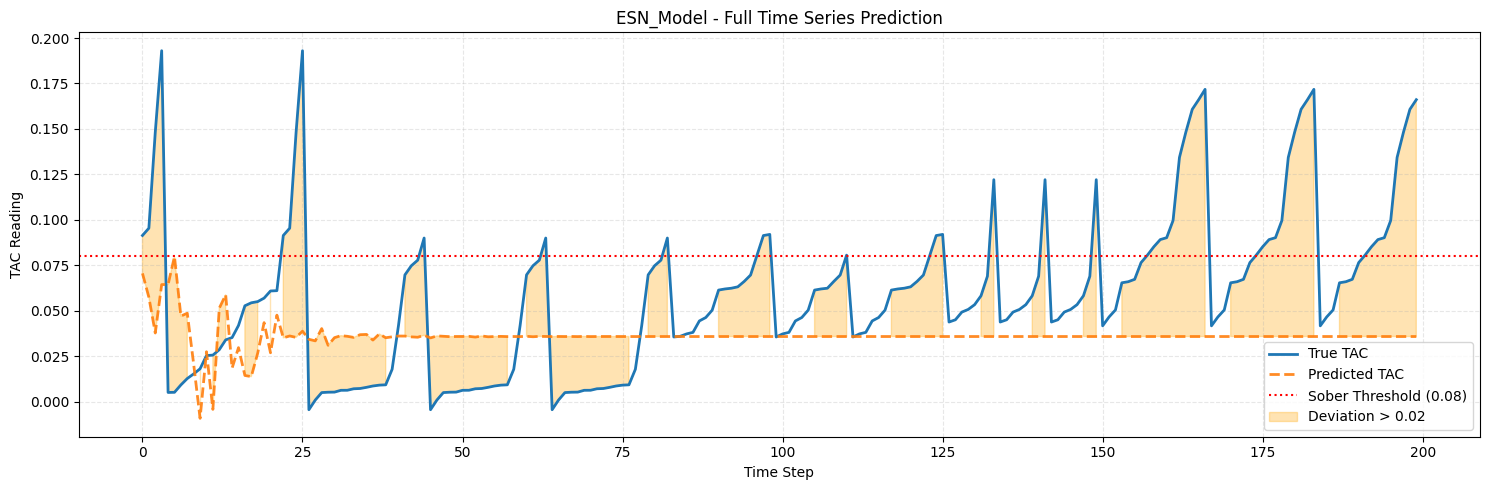

In [387]:
plot_esn_full_predictions(y_true, y_pred, model_name="ESN_Model")
